In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('kern_c.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
0,93205,Kern County,1,2015,Residential,713626.0,0.713626
1,93215,Kern County,1,2015,Residential,5653336.0,5.653336
2,93215,Kern County,1,2015,Commercial,4239412.0,4.239412
3,93222,Kern County,1,2015,Residential,771854.0,0.771854
4,93225,Kern County,1,2015,Residential,1597884.0,1.597884


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ZipCode        4581 non-null   int64  
 1   County         4581 non-null   object 
 2   Month          4581 non-null   int64  
 3   Year           4581 non-null   int64  
 4   CustomerClass  4581 non-null   object 
 5   TotalkWh       4581 non-null   float64
 6   TotalGWh       4581 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 250.7+ KB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ZipCode        4581 non-null   int64         
 1   County         4581 non-null   object        
 2   Month          4581 non-null   int64         
 3   Year           4581 non-null   int64         
 4   CustomerClass  4581 non-null   object        
 5   TotalkWh       4581 non-null   float64       
 6   TotalGWh       4581 non-null   float64       
 7   Date           4581 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 286.4+ KB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,93205,Kern County,1,2015,Residential,713626.0,0.713626
2015-01-01,93215,Kern County,1,2015,Residential,5653336.0,5.653336
2015-01-01,93215,Kern County,1,2015,Commercial,4239412.0,4.239412
2015-01-01,93222,Kern County,1,2015,Residential,771854.0,0.771854
2015-01-01,93225,Kern County,1,2015,Residential,1597884.0,1.597884


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,58275442.0,58.275442
2015-02-28,51889793.0,51.889793
2015-03-31,56702979.0,56.702979
2015-04-30,122336169.0,122.336169
2015-05-31,74172881.0,74.172881


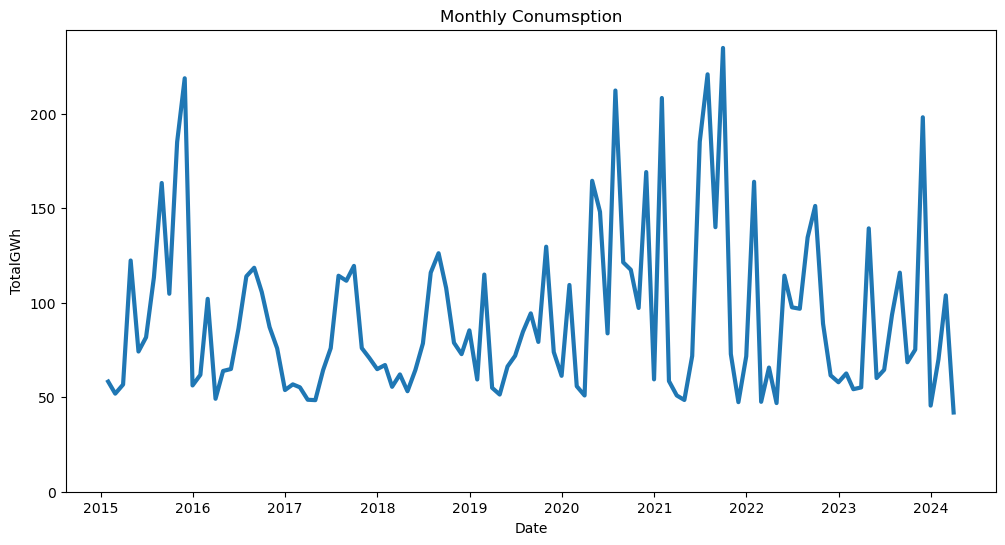

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Conumsption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMA model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.751497980314887
p-value: 0.4047933115042195
Non-Stationary


***SARIMAX model can still handle non-stationary data***

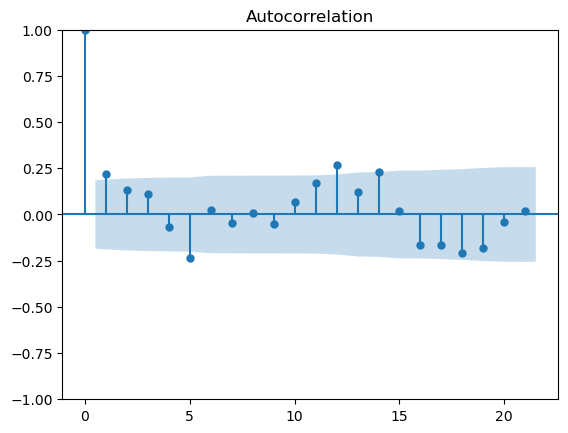

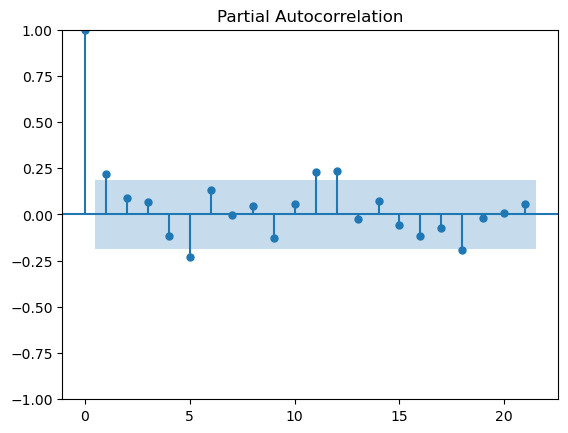

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1199.577, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1177.106, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1197.578, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1177.765, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1177.423, Time=0.39 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1175.619, Time=0.13 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1173.540, Time=0.34 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1193.630, Time=0.36 sec
 ARIMA(2,1,0)(0,0,2)[12] intercept   : AIC=1162.487, Time=0.50 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1162.454, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : 

In [18]:
# p, d, q parameters
model.order

(2, 1, 0)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(0, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results

# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

### Forecasting the next 12 months

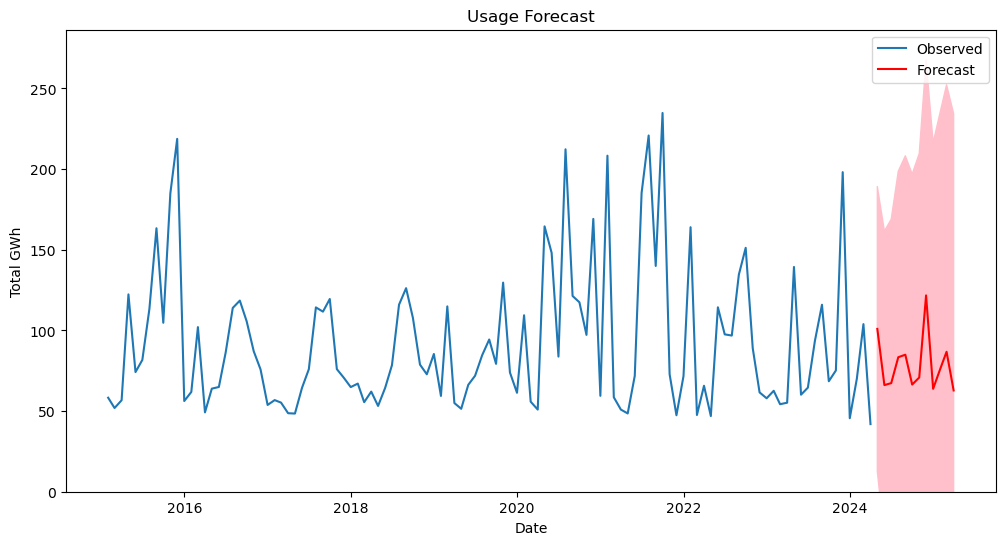

In [21]:
# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(bottom=0)
plt.legend()
plt.show()

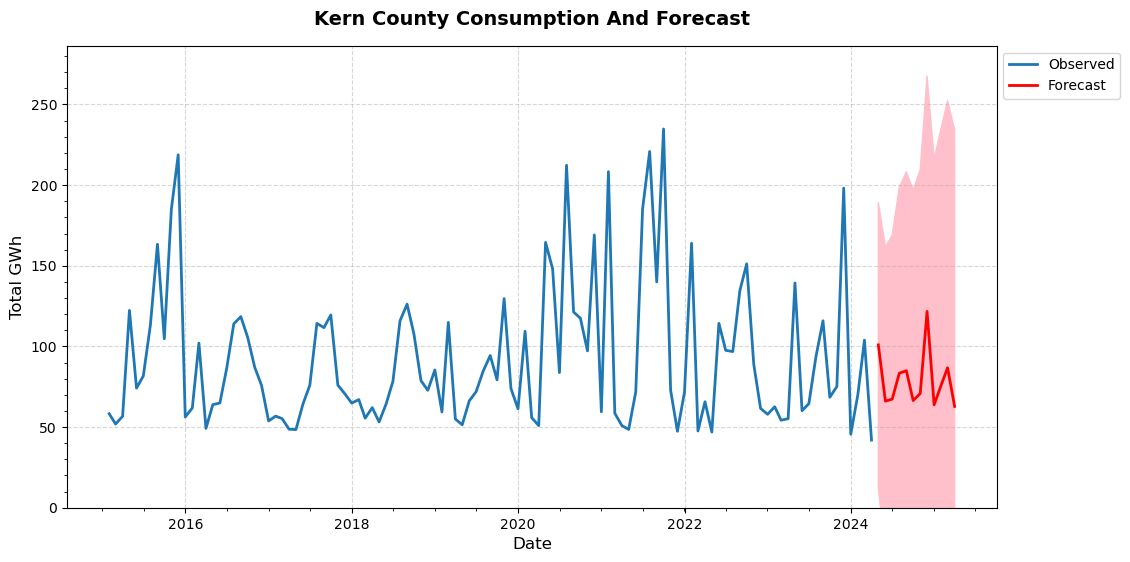

In [22]:
# Alternative Plot
from matplotlib.ticker import AutoMinorLocator


# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("Kern County Consumption And Forecast", weight='bold', fontsize=14, pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14,1), loc='upper right')

# Show plot
plt.show()

### Evaluate Model

In [23]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 19.454170556037308
MSE: 795.1415542167482
RMSE: 28.198254453365518


In [24]:
observed

Date
2023-04-30    139.345263
2023-05-31     60.149056
2023-06-30     64.516078
2023-07-31     93.569078
2023-08-31    115.908125
2023-09-30     68.494153
2023-10-31     75.167494
2023-11-30    198.118847
2023-12-31     45.561908
2024-01-31     70.029007
2024-02-29    103.896656
2024-03-31     41.919411
Freq: M, Name: TotalGWh, dtype: float64

In [25]:
forecast_mean

2024-04-30    100.936801
2024-05-31     66.101043
2024-06-30     67.326347
2024-07-31     83.380288
2024-08-31     84.944053
2024-09-30     66.432822
2024-10-31     70.799643
2024-11-30    121.706999
2024-12-31     63.794382
2025-01-31     76.063961
2025-02-28     86.752288
2025-03-31     62.793054
Freq: M, Name: predicted_mean, dtype: float64

### Forecasting the next 24 months

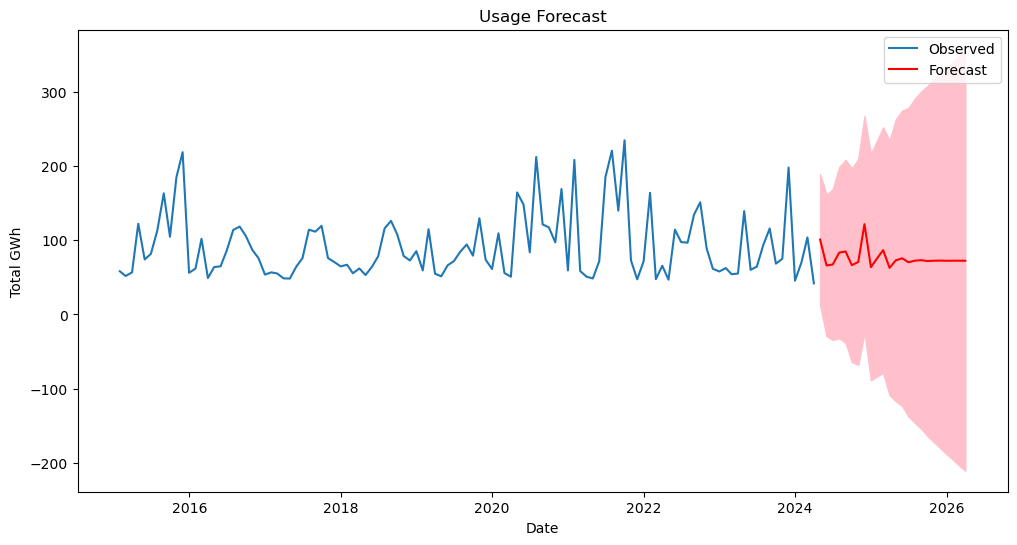

In [26]:
# Forecast future demand
forecast_periods = 24  # Forecast the next 24 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.legend()
plt.show()

### Evaluate Model

In [27]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 33.0203032352899
MSE: 1942.2678186678465
RMSE: 44.07116765718656


In [28]:
observed

Date
2022-04-30     46.911935
2022-05-31    114.315645
2022-06-30     97.559747
2022-07-31     96.811143
2022-08-31    134.557434
2022-09-30    151.197763
2022-10-31     88.955367
2022-11-30     61.571296
2022-12-31     57.922385
2023-01-31     62.579734
2023-02-28     54.253495
2023-03-31     55.187284
2023-04-30    139.345263
2023-05-31     60.149056
2023-06-30     64.516078
2023-07-31     93.569078
2023-08-31    115.908125
2023-09-30     68.494153
2023-10-31     75.167494
2023-11-30    198.118847
2023-12-31     45.561908
2024-01-31     70.029007
2024-02-29    103.896656
2024-03-31     41.919411
Freq: M, Name: TotalGWh, dtype: float64

In [29]:
forecast_mean

2024-04-30    100.936801
2024-05-31     66.101043
2024-06-30     67.326347
2024-07-31     83.380288
2024-08-31     84.944053
2024-09-30     66.432822
2024-10-31     70.799643
2024-11-30    121.706999
2024-12-31     63.794382
2025-01-31     76.063961
2025-02-28     86.752288
2025-03-31     62.793054
2025-04-30     72.978175
2025-05-31     75.712301
2025-06-30     70.400680
2025-07-31     72.526016
2025-08-31     73.210072
2025-09-30     72.035008
2025-10-31     72.476371
2025-11-30     72.644627
2025-12-31     72.385215
2026-01-31     72.476380
2026-02-28     72.517209
2026-03-31     72.460058
Freq: M, Name: predicted_mean, dtype: float64

In [30]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural    1763.781438
Commercial      2323.240900
Industrial      1934.912486
Residential     4239.782401
Name: TotalGWh, dtype: float64

In [31]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,1763.781438
1,Commercial,2323.240900
2,Industrial,1934.912486
3,Residential,4239.782401


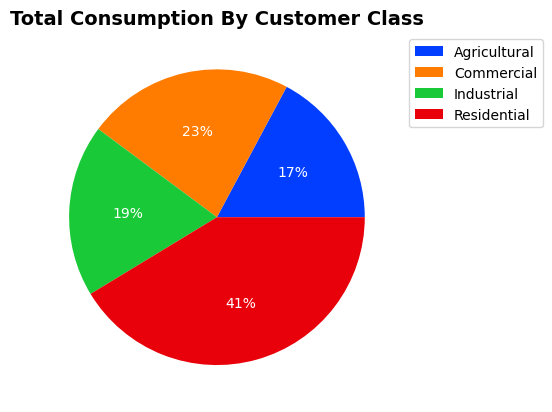

In [32]:
# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'],colors=palette_color, autopct='%.0f%%', textprops=dict(color='w'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

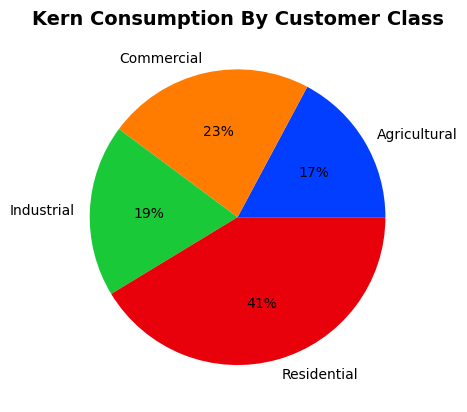

In [33]:
# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'],labels=customer_df['CustomerClass'],colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Kern Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()